In [279]:
#!pip install autokeras
#!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc4

In [280]:
#Prepare Data
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

opp_dataset = pd.read_csv('OpportunityValueDuration.csv')
opp_dataset = opp_dataset.replace(np.nan, 0, regex=True)
display(opp_dataset[opp_dataset['Project Price'] < 0])
df = opp_dataset.drop(['Project Title - ID', 'Opportunity Name - ID','Close Date','Managing Fin Entity ID'], axis = 1) 
#df_plot = df.groupby(['Currency Code'])['Project Price'].sum().reset_index()
df.describe().transpose()

,Project Title - ID,Opportunity Name - ID,Close Date,Managing Fin Entity ID,Currency Code,Project Price_,Project Price,Current Project Duration


,count,mean,std,min,25%,50%,75%,max
Project Price_,1036.0,2.233335e+06,1.089571e+07,1.00,50000.00,200000.00,660000.000,1.300160e+08
Project Price,1036.0,3.430423e+05,5.473379e+05,0.00,35375.00,150000.00,485000.000,9.491360e+06
Current Project Duration,1036.0,1.371273e+01,1.607365e+01,0.14,3.71,8.71,16.605,1.057100e+02


In [281]:
from pandas.api.types import is_numeric_dtype
def remove_outlier(df):
	    low = .05
	    high = .95
	    quant_df = df.quantile([low, high])
	    for name in list(df.columns):
	      if is_numeric_dtype(df[name]):
	       df = df[(df[name] > quant_df.loc[low, name]) 
               & (df[name] < quant_df.loc[high, name])]
	    return df
df_out = remove_outlier(df)
#df_out = remove_outlier(df_out)
display(df_out.describe().transpose())
display(df_out)

,count,mean,std,min,25%,50%,75%,max
Project Price_,786.0,353463.650127,490488.171285,5462.00,53875.0,174500.00,493750.00,3650000.0
Project Price,786.0,276649.940611,288477.748000,3952.50,50000.0,150000.00,435660.05,1180000.0
Current Project Duration,786.0,11.024911,10.205444,0.29,4.0,7.71,14.71,52.0


,Currency Code,Project Price_,Project Price,Current Project Duration
0,CNY,1350000.0,195615.00,6.71
1,CNY,1196712.0,173523.24,3.71
2,CNY,300000.0,42240.00,1.71
3,CNY,260000.0,38532.00,1.71
4,CNY,350000.0,52115.00,0.71
...,...,...,...,...
1030,USD,12000.0,12000.00,0.29
1032,USD,150000.0,150000.00,49.00
1033,USD,50000.0,50000.00,1.71
1034,USD,32000.0,32000.00,1.71


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


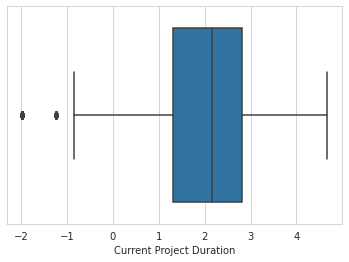

In [282]:
df_ln = df.copy()
df_ln['Current Project Duration'] = np.log(df_ln['Current Project Duration']) # converting to days
df_ln['Project Price'] = np.log(df_ln['Project Price'])
df_ln['Project Price_'] = np.log(df_ln['Project Price_'])
#df['Current Project Duration'].plot(kind='hist')
df_ln1 = df_ln
sns.boxplot(x=df_ln1['Current Project Duration'])
#exclude_lt_0 = (df['Current Project Duration'] > 0) and (df['Project Price'] > 0)
df_ln1.head()
df_ln1.to_csv('OppValueDurationLn.csv', index=False)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


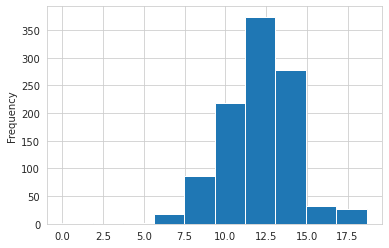

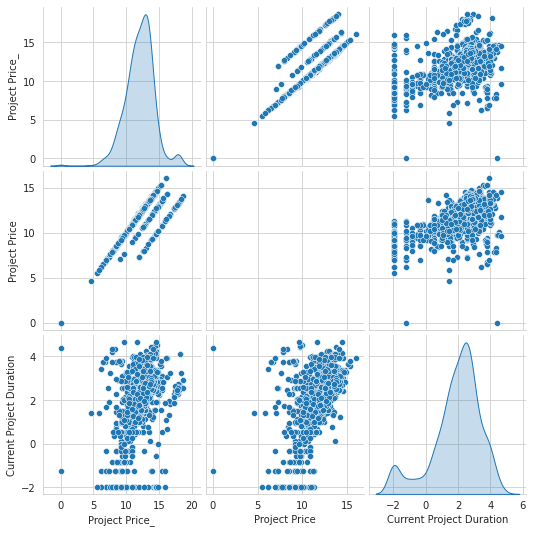

In [284]:
df_ln1['Project Price_'].plot(kind='hist')
sns.pairplot(df_ln1, diag_kind='kde')

OPTIMAL
[ 8.56138134  9.52770233 10.19733095 10.70318127 11.20949793 11.75567913
 12.03763628 12.35913467 12.65407562 12.95392752 13.26637936 13.58104086
 13.84126186 14.32973957 15.11973619]
                   Bin  Count  Count (%)           Sum       Mean        Min  \
0         [-inf, 8.56)     63   0.060811    467.984757   7.428329   0.000000   
1         [8.56, 9.53)     58   0.055985    529.537967   9.129965   8.605570   
2        [9.53, 10.20)     67   0.064672    665.837434   9.937872   9.546813   
3       [10.20, 10.70)     54   0.052124    564.873648  10.460623  10.203592   
4       [10.70, 11.21)     85   0.082046    930.695964  10.949364  10.714418   
5       [11.21, 11.76)     98   0.094595   1122.809788  11.457243  11.225243   
6       [11.76, 12.04)     65   0.062741    773.669817  11.902613  11.775290   
7       [12.04, 12.36)     52   0.050193    633.719019  12.186904  12.043554   
8       [12.36, 12.65)     62   0.059846    775.907731  12.514641  12.372434   
9       

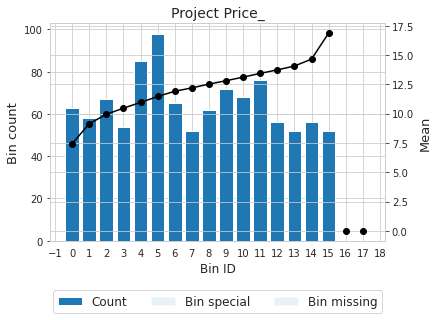

[11.21, 11.76)    98
[10.70, 11.21)    85
[13.27, 13.58)    76
[12.65, 12.95)    72
[12.95, 13.27)    68
[9.53, 10.20)     67
[11.76, 12.04)    65
[-inf, 8.56)      63
[12.36, 12.65)    62
[8.56, 9.53)      58
[13.58, 13.84)    56
[14.33, 15.12)    56
[10.20, 10.70)    54
[15.12, inf)      52
[13.84, 14.33)    52
[12.04, 12.36)    52
dtype: int64
-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       1.64883004
    HHI                      0.06485070
    HHI (normalized)         0.00984192

  Monotonic trend             ascending



,Currency Code,Project Price_,Project Price,Current Project Duration,Project Price_ Mean
0,CNY,14.115615,12.183904,1.903599,"[13.84, 14.33)"
1,CNY,13.995088,12.064067,1.311032,"[13.84, 14.33)"
2,CNY,12.611538,10.651123,0.536493,"[12.36, 12.65)"
3,CNY,12.468437,10.559244,0.536493,"[12.36, 12.65)"
4,CNY,12.765688,10.861208,-0.342490,"[12.65, 12.95)"
...,...,...,...,...,...
1031,USD,9.210340,9.210340,-1.966113,"[8.56, 9.53)"
1032,USD,11.918391,11.918391,3.891820,"[11.76, 12.04)"
1033,USD,10.819778,10.819778,0.536493,"[10.70, 11.21)"
1034,USD,10.373491,10.373491,0.536493,"[10.20, 10.70)"


In [285]:
# optimal binning for Project Price
#!pip install optbinning
from optbinning import ContinuousOptimalBinning

df_bin = df_ln1
variable = 'Project Price_'
target = 'Project Price_'
x = df_bin[variable].values
y = df_bin[target]
optb = ContinuousOptimalBinning(name=variable, dtype="numerical")
optb.fit(x, y)
print(optb.status)
print(optb.splits)
binning_table = optb.binning_table
type(binning_table)
print(binning_table.build())
binning_table.plot()
x_transform_mean = optb.transform(x, metric="bins")
df_bin['Project Price_ Mean'] = x_transform_mean
print(pd.Series(x_transform_mean).value_counts())
binning_table.analysis()
df_bin

In [286]:
df_ln1.groupby(['Currency Code','Project Price_ Mean'])['Project Price_'].median().reset_index()

,Currency Code,Project Price_ Mean,Project Price_
0,CNY,"[10.70, 11.21)",10.819778
1,CNY,"[11.21, 11.76)",11.379125
2,CNY,"[11.76, 12.04)",11.806020
3,CNY,"[12.36, 12.65)",12.577041
4,CNY,"[12.65, 12.95)",12.806807
5,CNY,"[13.27, 13.58)",13.421782
6,CNY,"[13.58, 13.84)",13.592367
7,CNY,"[13.84, 14.33)",13.996460
8,CNY,"[14.33, 15.12)",14.862214
9,CNY,"[15.12, inf)",15.450531


OPTIMAL
[-0.7030445   0.61482027  1.07471699  1.40349507  1.59523821  1.95581144
  2.15636981  2.32383025  2.49070621  2.63900733  2.8033514   2.99191701
  3.42470801  3.87848055]
                  Bin  Count  Count (%)          Sum      Mean       Min  \
0       [-inf, -0.70)     91   0.087838  -152.342263 -1.674091 -1.966113   
1       [-0.70, 0.61)     83   0.080116    18.584385  0.223908 -0.562119   
2        [0.61, 1.07)     56   0.054054    50.492040  0.901644  0.693147   
3        [1.07, 1.40)     56   0.054054    70.532729  1.259513  1.098612   
4        [1.40, 1.60)     75   0.072394   112.880016  1.505067  1.420696   
5        [1.60, 1.96)    100   0.096525   179.288863  1.792889  1.609438   
6        [1.96, 2.16)     53   0.051158   108.968977  2.056018  1.965713   
7        [2.16, 2.32)     54   0.052124   120.915981  2.239185  2.164472   
8        [2.32, 2.49)     75   0.072394   181.437197  2.419163  2.331173   
9        [2.49, 2.64)     73   0.070463   187.389407  2.5669

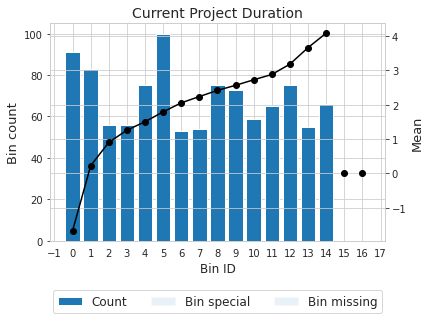

[1.60, 1.96)     100
[-inf, -0.70)     91
[-0.70, 0.61)     83
[1.40, 1.60)      75
[2.99, 3.42)      75
[2.32, 2.49)      75
[2.49, 2.64)      73
[3.88, inf)       66
[2.80, 2.99)      65
[2.64, 2.80)      59
[0.61, 1.07)      56
[1.07, 1.40)      56
[3.42, 3.88)      55
[2.16, 2.32)      54
[1.96, 2.16)      53
dtype: int64
-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       1.12421774
    HHI                      0.06937322
    HHI (normalized)         0.01120905

  Monotonic trend             ascending



,Currency Code,Project Price_,Project Price,Current Project Duration,Project Price_ Mean,Duration Mean
0,CNY,14.115615,12.183904,1.903599,"[13.84, 14.33)","[1.60, 1.96)"
1,CNY,13.995088,12.064067,1.311032,"[13.84, 14.33)","[1.07, 1.40)"
2,CNY,12.611538,10.651123,0.536493,"[12.36, 12.65)","[-0.70, 0.61)"
3,CNY,12.468437,10.559244,0.536493,"[12.36, 12.65)","[-0.70, 0.61)"
4,CNY,12.765688,10.861208,-0.342490,"[12.65, 12.95)","[-0.70, 0.61)"
...,...,...,...,...,...,...
1031,USD,9.210340,9.210340,-1.966113,"[8.56, 9.53)","[-inf, -0.70)"
1032,USD,11.918391,11.918391,3.891820,"[11.76, 12.04)","[3.88, inf)"
1033,USD,10.819778,10.819778,0.536493,"[10.70, 11.21)","[-0.70, 0.61)"
1034,USD,10.373491,10.373491,0.536493,"[10.20, 10.70)","[-0.70, 0.61)"


In [287]:
#Optimal binning for duration
# optimal binning for Project Price
#!pip install optbinning
from optbinning import ContinuousOptimalBinning

#df_plot = df.groupby(['Currency Code'])['Duration'].sum().reset_index()
#df_plot['Project Price'].plot(kind='hist')

df_bin1 = df_ln1
variable = 'Current Project Duration'
target = 'Current Project Duration'
x = df_bin1[variable].values
y = df_bin1[target]
optb = ContinuousOptimalBinning(name=variable, dtype="numerical")#, outlier_detector='zscore')
optb.fit(x, y)
print(optb.status)
print(optb.splits)
binning_table = optb.binning_table
type(binning_table)
print(binning_table.build())
binning_table.plot()
x_transform_mean = optb.transform(x, metric="bins")
df_bin['Duration Mean'] = x_transform_mean
print(pd.Series(x_transform_mean).value_counts())
binning_table.analysis()
df_bin

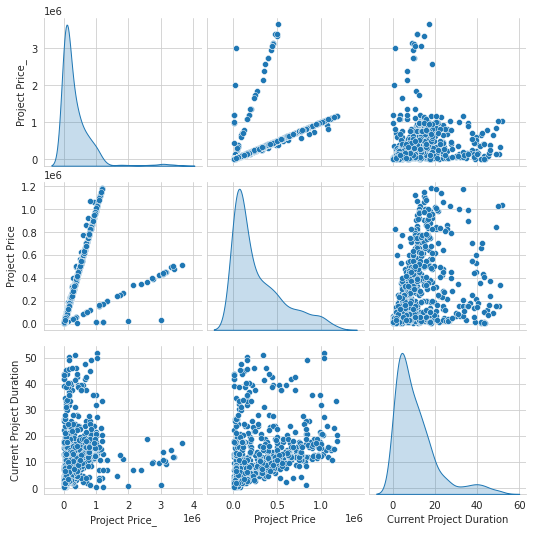

In [288]:
#cols = df_bin.columns
sns.pairplot(df_out, diag_kind='kde')

In [289]:
df_out.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Project Price_,786.0,353463.650127,490488.171285,5462.00,53875.0,174500.00,493750.00,3650000.0
Project Price,786.0,276649.940611,288477.748000,3952.50,50000.0,150000.00,435660.05,1180000.0
Current Project Duration,786.0,11.024911,10.205444,0.29,4.0,7.71,14.71,52.0


In [290]:
#Split into train and test
from sklearn.model_selection import train_test_split
df1 = df_out.copy()
test_size = 0.2
target_col = 'Current Project Duration'
df_cols = set(df1.columns)
y_cols = [target_col]
x_cols = df_cols - set([target_col])
x_train, x_test, y_train, y_test = train_test_split(df1[x_cols],df1[y_cols], test_size = test_size, random_state = 0)
print(type(x_train), type(y_train), type(x_test), type(y_test))
x_train

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


,Currency Code,Project Price,Project Price_
598,USD,84115.0,84115.0
672,USD,380000.0,380000.0
777,USD,34500.0,34500.0
368,USD,20000.0,20000.0
640,USD,100000.0,100000.0
...,...,...,...
1009,USD,240000.0,240000.0
299,USD,35000.0,35000.0
829,USD,1029000.0,1029000.0
736,USD,661320.0,661320.0


In [291]:
y_train

,Current Project Duration
598,3.71
672,9.00
777,8.86
368,0.43
640,1.71
...,...
1009,46.00
299,1.57
829,50.00
736,12.43


In [292]:
#Split into train and test
#cols = list(opp.select_dtypes(include='float64').columns)
#dataset = opp[cols]
#train_size = 0.8
#df1 = df_out.copy()
#train = df1.sample(frac=train_size, random_state=0)
#test = df1.drop(train.index)
#train_size = int(df.shape[0] * 0.9)
#train = df[:train_size]
#test = df[train_size:]
#train.to_csv('train.csv', index=False)
#test.to_csv('eval.csv', index=False)
#train_file_path = 'train.csv'
#test_file_path = 'eval.csv'

In [293]:
test

,Currency Code,Project Price,Project Price_
0,CNY,195615.00,1350000.0
1,CNY,173523.24,1196712.0
2,CNY,42240.00,300000.0
3,CNY,38532.00,260000.0
4,CNY,52115.00,350000.0
...,...,...,...
1030,USD,12000.00,12000.0
1032,USD,150000.00,150000.0
1033,USD,50000.00,50000.0
1034,USD,32000.00,32000.0


In [294]:
#how the data can be prepared with numpy.ndarray, pandas.DataFrame, and tensorflow.data.Dataset.
#import pandas as pd
#import numpy as np
#x_train = train.copy() #pd.read_csv(train_file_path)
#print(type(x_train)) # pandas.DataFrame
#y_train = x_train.pop('Current Project Duration')
#print(type(y_train)) # pandas.Series

# You can also use pandas.DataFrame for y_train.
#y_train = pd.DataFrame(y_train)
#print(type(y_train)) # pandas.DataFrame

# You can also use numpy.ndarray for x_train and y_train.
#x_train = x_train.to_numpy()
#y_train = y_train.to_numpy()
#print(type(x_train)) # numpy.ndarray
#print(type(y_train)) # numpy.ndarray

# Preparing testing data.
#x_test = test.copy() #pd.read_csv(test_file_path)
#y_test = x_test.pop('Current Project Duration')
#y_test = pd.DataFrame(y_test)
#print(type(x_train), type(y_train), type(x_test), type(y_test))

In [295]:
# It tries 10 different models if you set epochs = 10.
input_node = ak.StructuredDataInput()
output_node = ak.StructuredDataBlock(categorical_encoding=True,normalize=True)(input_node)
#output_node = ak.DenseBlock()(output_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node, 
    outputs=output_node, 
    overwrite=True,
    max_trials=5)
reg.fit(x_train, y_train)#, epochs=10)
# Predict with the best model.
predicted_y = reg.predict(x_test)
# Evaluate the best model with testing data.
mae, _ = reg.evaluate(x_test, y_test)
print('MAE: %.3f' % mae)

Trial 5 Complete [00h 00m 45s]
val_loss: 87.97179412841797

Best val_loss So Far: 87.2125015258789
Total elapsed time: 00h 04m 47s
Epoch 1/55
20/20 [==============================] - 0s 3ms/step - loss: 158.5147 - mean_squared_error: 158.5147
Epoch 2/55
20/20 [==============================] - 0s 3ms/step - loss: 100.8437 - mean_squared_error: 100.8437
Epoch 3/55
20/20 [==============================] - 0s 3ms/step - loss: 100.5835 - mean_squared_error: 100.5835
Epoch 4/55
20/20 [==============================] - 0s 3ms/step - loss: 96.2180 - mean_squared_error: 96.2180
Epoch 5/55
20/20 [==============================] - 0s 3ms/step - loss: 95.5123 - mean_squared_error: 95.5123
Epoch 6/55
20/20 [==============================] - 0s 3ms/step - loss: 95.2333 - mean_squared_error: 95.2333
Epoch 7/55
20/20 [==============================] - 0s 3ms/step - loss: 95.4740 - mean_squared_error: 95.4740
Epoch 8/55
20/20 [==============================] - 0s 3ms/step - loss: 96.6989 - mean_square

WARNING - 11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x7fd574192a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
WARNING - 11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x7fd528780f28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function r

5/5 [==============================] - 0s 2ms/step - loss: 85.3391 - mean_squared_error: 85.3391
MAE: 85.339


In [296]:
# get the best performing model
model = reg.export_model()
# summarize the loaded model
model.summary()

WARNING - 11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x7fd509b4d268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 3)                 0         
_________________________________________________________________
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)               

WARNING - 11 out of the last 11 calls to <function recreate_function.<locals>.restored_function_body at 0x7fd57414b268> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


X=    Currency Code  Project Price_  Project Price
0             CNY       1350000.0      195615.00
1             CNY       1196712.0      173523.24
2             CNY        300000.0       42240.00
3             CNY        260000.0       38532.00
4             CNY        350000.0       52115.00
..            ...             ...            ...
781           USD         12000.0       12000.00
782           USD        150000.0      150000.00
783           USD         50000.0       50000.00
784           USD         32000.0       32000.00
785           USD        125000.0      125000.00

[786 rows x 3 columns], Predicted=     Predicted Duration
0             16.568270
1             15.640560
2              7.426501
3              6.539174
4              8.683140
..                  ...
781            8.170870
782           10.140976
783            8.431007
784            8.277124
785            9.772507

[786 rows x 1 columns]


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Currency Code,Project Price_,Project Price,Current Project Duration,Predicted Duration
0,CNY,inf,inf,820.57,1.568585e+07
1,CNY,inf,inf,40.85,6.203102e+06
2,CNY,inf,inf,5.53,1.679920e+03
3,CNY,inf,inf,5.53,6.917100e+02
4,CNY,inf,inf,2.03,5.902550e+03


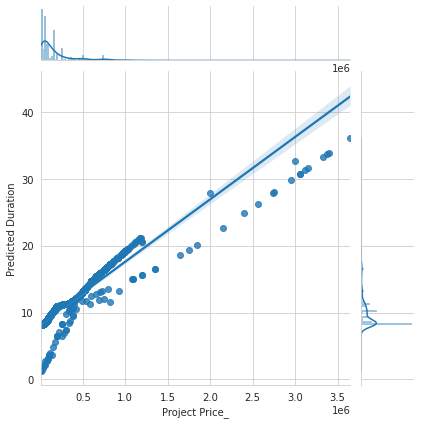

In [297]:
# use the model to make a prediction
df1 = df_out.copy().reset_index(drop=True)
org_df = df1.drop(columns = 'Current Project Duration')
yhat = reg.predict(org_df)
yhat_df = pd.DataFrame(yhat, columns = ['Predicted Duration'])
print("X=%s, Predicted=%s" % (org_df, yhat_df))
xy = pd.concat([org_df,yhat_df], axis=1)
xy_df = pd.merge(df_out,xy,how='inner')
sns.jointplot(data=xy_df, x='Project Price_', y='Predicted Duration', kind='reg')
xy_df['Predicted Duration'] = round(np.exp(xy_df['Predicted Duration']),2)
xy_df['Current Project Duration'] = round(np.exp(xy_df['Current Project Duration']),2)
xy_df['Project Price'] = round(np.exp(xy_df['Project Price']),0)
xy_df['Project Price_'] = round(np.exp(xy_df['Project Price_']),0)
xy_df.head()

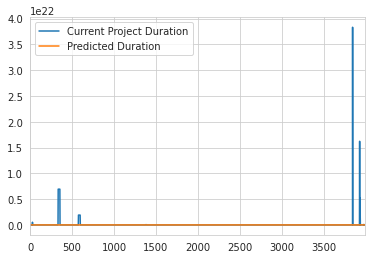

In [298]:
xy_df[['Current Project Duration','Predicted Duration']].plot()

In [299]:
xy_df[xy_df['Current Project Duration'] < 2]

,Currency Code,Project Price_,Project Price,Current Project Duration,Predicted Duration
42,EUR,inf,inf,1.34,3.700000e+00
43,EUR,inf,inf,1.34,3.710000e+00
51,EUR,inf,inf,1.54,4.290000e+00
76,JPY,inf,inf,1.34,1.862518e+08
77,JPY,inf,inf,1.34,8.973459e+08
...,...,...,...,...,...
3563,USD,inf,inf,1.54,4.098870e+03
3586,USD,inf,inf,1.77,3.526630e+03
3841,USD,inf,inf,1.77,3.635230e+03
3842,USD,inf,inf,1.77,3.635230e+03


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Duration]')
  plt.legend()
  plt.grid(True)
plot_loss(yhat)

In [ ]:
def plot_duration(x, y):
  plt.scatter(xy_df['Current Project Duration'], xy_df['Predicted Duration'], label='Data')
  #plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Current Project Duration')
  plt.ylabel('Predicted Duration')
  plt.legend()
plot_duration(xy_df['Current Project Duration'],xy_df['Predicted Duration'])


In [ ]:
sns.distplot(xy_df['Predicted Duration'])

In [ ]:
sns.jointplot(data=xy_df, x='Project Price', y='Predicted Duration', kind='reg')

In [ ]:
sns.jointplot(data=df, x='Project Price_', y='Current Project Duration', hue='Currency', kind='reg')